In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/news-summary/news_summary.csv
/kaggle/input/news-summary/news_summary_more.csv


In [2]:
summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding='iso-8859-1')

In [3]:
summary.head(2)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."


In [4]:
raw.head(2)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...


In [5]:
pre1 =  raw.iloc[:,0:2].copy()
pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 

pre2 = summary.iloc[:,0:6].copy()
pre2['head + text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['headlines'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " "),sep= " ")

In [6]:
pre1.head(2)

,headlines,text,head + text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


In [7]:
pre2.head(2)

,author,date,headlines,read_more,text,ctext,head + text
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...,"Chhavi Tyagi 03 Aug 2017,Thursday Daman & Diu ..."
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo...","Daisy Mowke 03 Aug 2017,Thursday Malaika slams..."


In [8]:
pre = pd.DataFrame()
pre['head + text'] = pd.concat([pre1['head + text'], pre2['head + text']], ignore_index=True)

In [9]:
pre.head(2)

,head + text
0,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...


1. **(((STEP 1))) -  Create a W2V model more creating word vectors**
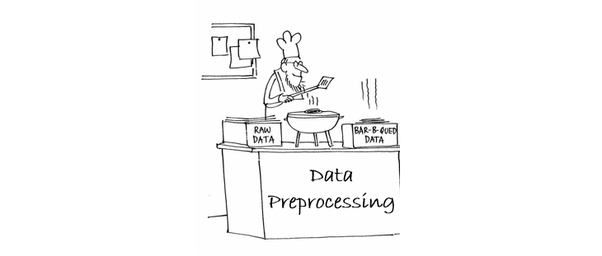
#Resource - https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [10]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [11]:
#DATA CLEANSING
#Scope for Improvement by loading lg model

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [12]:
#Removes non-alphabetic characters:
def text_strip():
    for row in pre['head + text']:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row


brief_cleaning = text_strip()

In [13]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 8.55 mins


In [14]:
txt[0]

'upgrad learner switch career ml al 90 % salary hike saurav kant alumnus upgrad iiit - b pg program machine learning artificial intelligence sr system engineer infosys year work experience program upgrad 360-degree career support help transition datum scientist tech mahindra 90 % salary hike upgrad online power learning power lakh+ career .'

In [15]:
pre_clean = pd.DataFrame({'cleaned head + text': txt})
pre_clean = pre_clean.dropna().drop_duplicates()
pre_clean.shape

(102768, 1)

In [16]:
# Bigrams:
# We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

# The main reason we do this is to catch words like "t_mobile" or "nbc_universal" !


from gensim.models.phrases import Phrases, Phraser

#Split the words by space
sent = [row.split() for row in pre_clean['cleaned head + text']]

#They should appear in the joint form minimum 50 times
#Phrases() takes a list of list of words as input:

phrases = Phrases(sent, min_count=50, progress_per=10000)


In [17]:
#The goal of Phraser() is to cut down memory consumption of Phrases(), 
#by discarding model state not strictly needed for the bigram detection task:
bigram = Phraser(phrases)

In [18]:
sentences  = bigram[sent]

In [19]:
#Sentences is basically a list of list fed to w2v for training
sentences[0]

['upgrad',
 'learner',
 'switch',
 'career',
 'ml',
 'al',
 '90_%',
 'salary_hike',
 'saurav',
 'kant',
 'alumnus',
 'upgrad',
 'iiit',
 '-',
 'b',
 'pg',
 'program',
 'machine',
 'learning',
 'artificial_intelligence',
 'sr',
 'system',
 'engineer',
 'infosys',
 'year',
 'work',
 'experience',
 'program',
 'upgrad',
 '360-degree',
 'career',
 'support',
 'help',
 'transition',
 'datum',
 'scientist',
 'tech_mahindra',
 '90_%',
 'salary_hike',
 'upgrad',
 'online',
 'power',
 'learning',
 'power',
 'lakh+',
 'career',
 '.']

In [20]:
#Sort the words by thier frequency and print them

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))

print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])


117526
['.', '-', 'say', 'india', 'add', 'year', 'government', 'woman', 'people', 'state']


**Generate a W2V model**
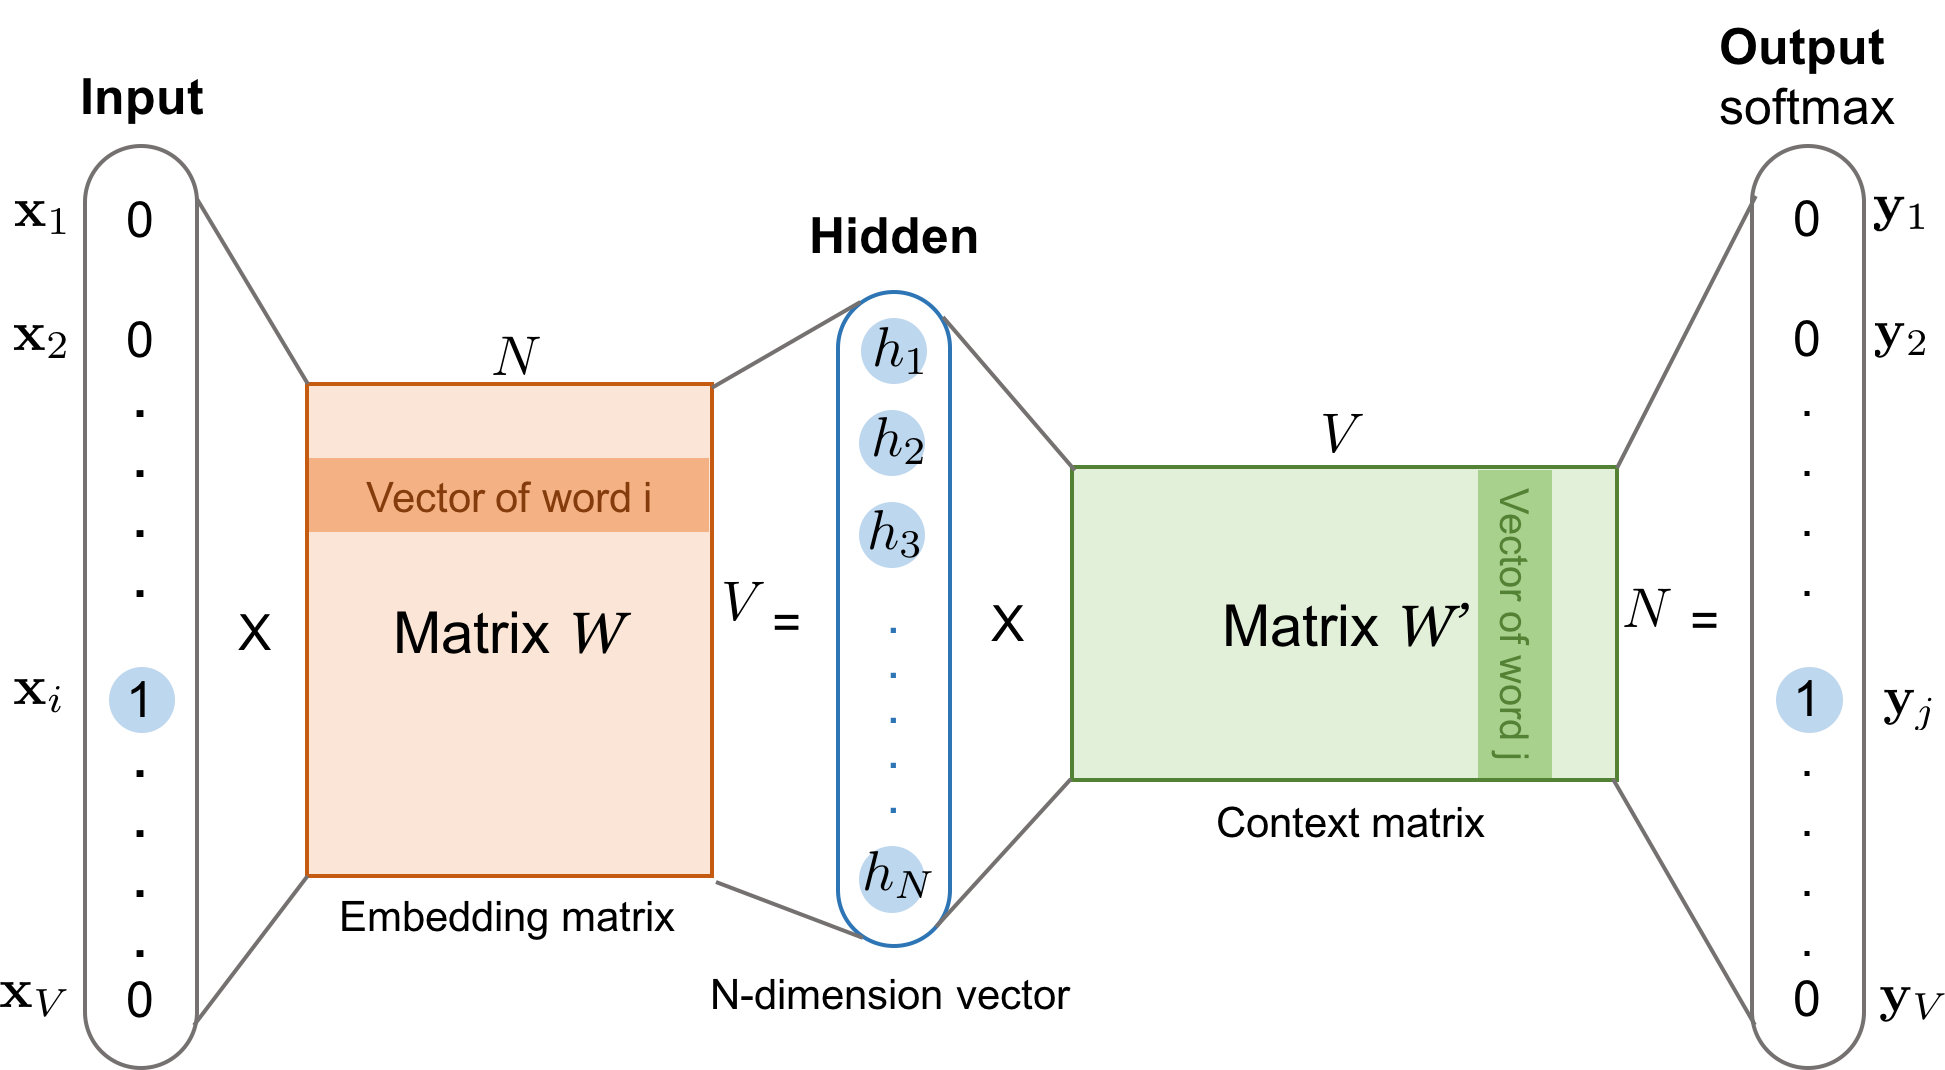

In [21]:
#---------------------Training the W2V Model-----------------------#

import multiprocessing
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

#initialize w2v parameters
w2v_model = Word2Vec(min_count=30,
                     window=2,
                     size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [22]:
#Build the Vocab of the w2v , but right now it is not trained on the sentences yet
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.4 mins


In [23]:
#Now actually train model on the list of list of words
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

#Takes 10 mins for 79mil words.
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 19.44 mins


In [24]:
#This makes the model memory-efficient
w2v_model.init_sims(replace=True)


In [25]:
#Save the Model to disk
w2v_model.save(fname_or_handle = "w2v_text_summ_200d_09162019")

**Data Visualization**

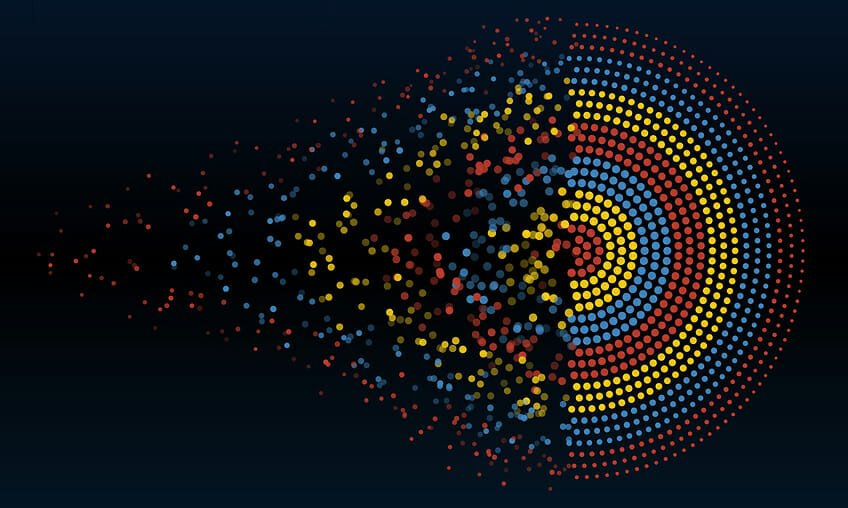

In [26]:
#-------------------------DATA VISUALIZATION--------------------------#
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim
from gensim.models import Word2Vec
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [27]:
#LOAD A W2V Model
MODEL_NAME = 'w2v_text_summ_200d_09162019'
EMAIL_W2V =  MODEL_NAME
email_model =  gensim.models.Word2Vec.load(EMAIL_W2V)


**The below are the methods which generate the plots**

In [28]:
import time

def tsne_plot(model):
    start =  time.time()
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    end = time.time()
    print('{} seconds taken to index the w2v model'.format(end-start))


    
    return x,y,labels

In [29]:
def matplot_plot(x,y,labels):
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [30]:
#--------------BOKEH PLOT------------------#
from bokeh.plotting import *
from bokeh.models import *
from bokeh.layouts import *
from bokeh.io import *
from bokeh.embed import *
from bokeh.resources import *
import pandas as pd
output_notebook() 
def bokehplotw2v(x,y,labels,MODEL_NAME):
    df = pd.DataFrame(list(zip(x, y, labels)),columns =['X', 'Y', 'LABELS']) 
    source = ColumnDataSource(data=df)
    labeled_w2v_plot = figure(plot_width=1500,title="Labelled W2V graph")
    labels = LabelSet(x='X', y='Y', text='LABELS', level='glyph',source=source,x_offset=5, y_offset=5)
    labeled_w2v_plot.circle(x, y)   
    labeled_w2v_plot.add_layout(labels)
    simple_w2v_plot = figure(plot_width=labeled_w2v_plot.plot_width, x_range=labeled_w2v_plot.x_range, y_range=labeled_w2v_plot.y_range,title="Simple W2V graph")
    simple_w2v_plot.circle(x, y)
    plot = column(labeled_w2v_plot, simple_w2v_plot)
    html_name = MODEL_NAME + '.html'
    output_file(html_name,mode='inline')
    show(plot)
    save(plot)




Loading BokehJS ...

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsnescatterplot(model, word, list_names,VECTOR_DIMENTION):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, VECTOR_DIMENTION), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    


In [32]:
#Index Entire Vocab (takes 16 mins for 79mil words)
x,y,labels = tsne_plot(email_model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


512.5246205329895 seconds taken to index the w2v model


In [33]:
# #Plot w2v in matplotlib
# matplot_plot(x,y,labels)

In [34]:
#Plot w2v in Bokeh
bokehplotw2v(x,y,labels,MODEL_NAME)

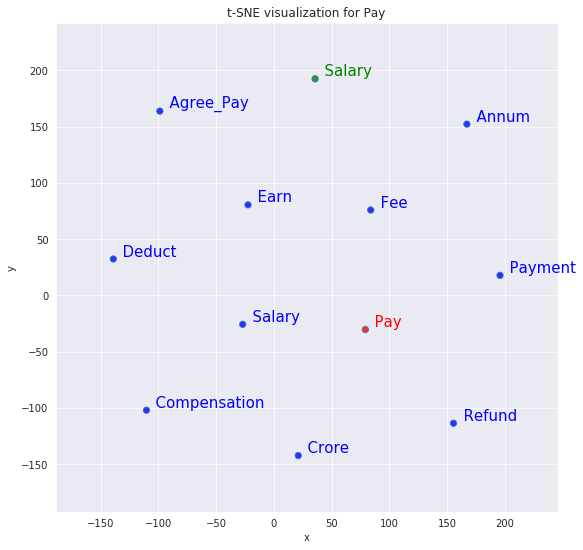

In [35]:
#10 Most similar words vs. n Random words:
WORD ='pay'
VECTOR_DIMENTION=200
list_names=['salary']
tsnescatterplot(email_model,WORD.lower(),list_names,VECTOR_DIMENTION)

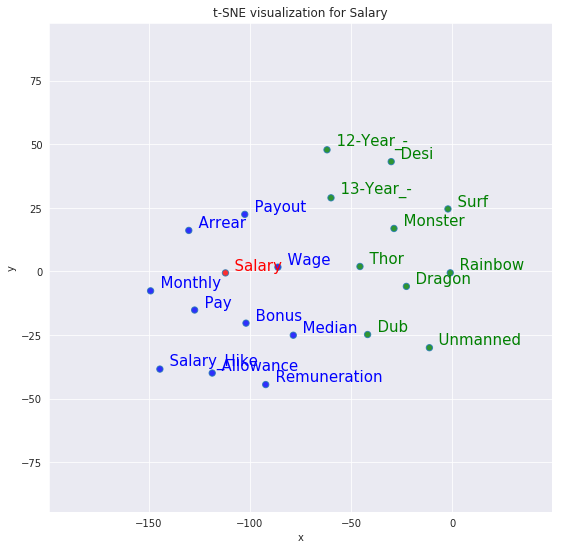

In [36]:
#10 Most similar words vs. 10 Most dissimilar

WORD ='salary'
VECTOR_DIMENTION=200
list_names=[i[0] for i in email_model.wv.most_similar(negative=[WORD.lower()])]
tsnescatterplot(email_model,WORD.lower(),list_names,VECTOR_DIMENTION )

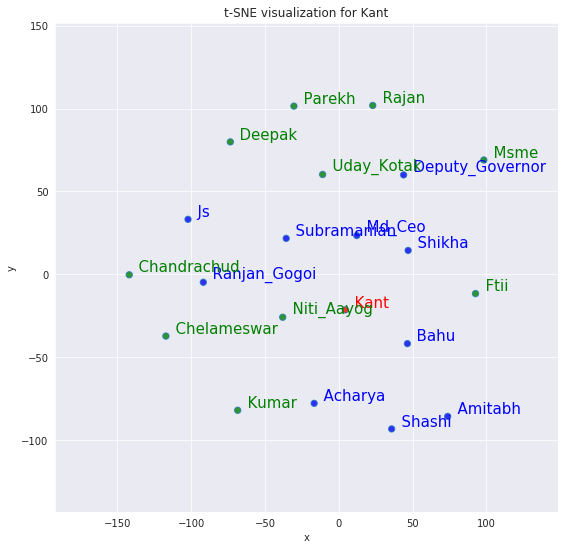

In [37]:
#10 Most similar words vs. 11th to 20th Most similar words:
    
WORD ='kant'
VECTOR_DIMENTION=200
list_names=[t[0] for t in email_model.wv.most_similar(positive=[WORD.lower()], topn=20)][10:]
tsnescatterplot(email_model, WORD.lower(),list_names,VECTOR_DIMENTION)